# Chapter 7 - Clustering-Based Recommender Systems

Recommender systems based on unsupervised machine learning algorithms are very popular because they overcome many challenges that collaborative, hybrid, and classification-based systems face. A clustering technique is used to recommend the products/items based on the patterns and behaviors captured within each segment/ cluster. This technique is good when data is limited, and there is no labeled data to work with.

Unsupervised learning is a machine learning category where labeled data is no leveraged, but still, inferences are discovered using the data at hand.y etc.

<div style="text-align:center;">
    <img src='images/cluster.jpg' width='400'>
</div>

In [1]:
# Importing libraries

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

import seaborn as sns
import os

from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

### Creating the Dataset

In [2]:
#read csv data

df_order = pd.read_excel('data/Rec_sys_data.xlsx','order')
df_customer = pd.read_excel('data/Rec_sys_data.xlsx','customer')
df_product = pd.read_excel('data/Rec_sys_data.xlsx','product')

In [3]:
df_order.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


In [4]:
df_customer.head()

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment
0,13089,male,53,High,8625,Small Business
1,15810,female,22,Low,87797,Small Business
2,15556,female,29,High,29257,Corporate
3,13137,male,29,Medium,97818,Middle class
4,16241,male,36,Low,79200,Small Business


In [5]:
df_product.head()

,StockCode,Product Name,Description,Category,Brand,Unit Price
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,"New unique design, great gift.High quality pla...",Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,Rounded rectangular cat-eye reading glasses. T...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,Each Nintendo 2DS kit is printed with super-hi...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,The sheerest compression stocking in its class...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38
4,84836,Stupell Industries Chevron Initial Wall D cor,Features: -Made in the USA. -Sawtooth hanger o...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99


### Pre Processing

In [6]:
def missing_zero_values_table(df):
    
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    
        return mz_table

# Check Missing Values
missing_zero_values_table(df_customer)

Your selected dataframe has 6 columns and 4372 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


### EDA

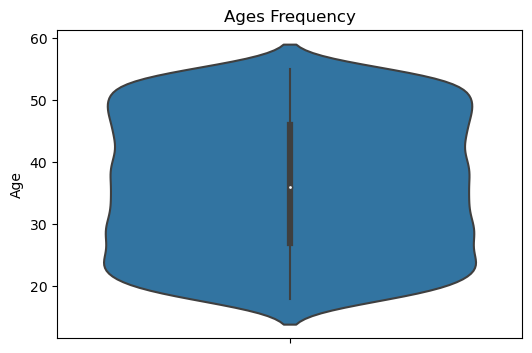

In [7]:
# Age Distribution

plt.figure(figsize=(6,4))
plt.title("Ages Frequency")
sns.axes_style("dark")
sns.violinplot(y=df_customer["Age"])
plt.show()

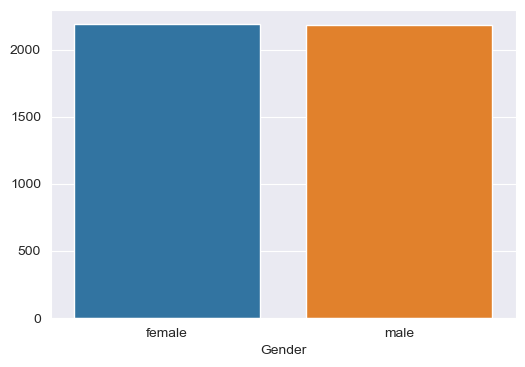

In [8]:
# Gender Distribution

genders = df_customer.Gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(6,4))
sns.barplot(x=genders.index, y=genders.values)
plt.show()

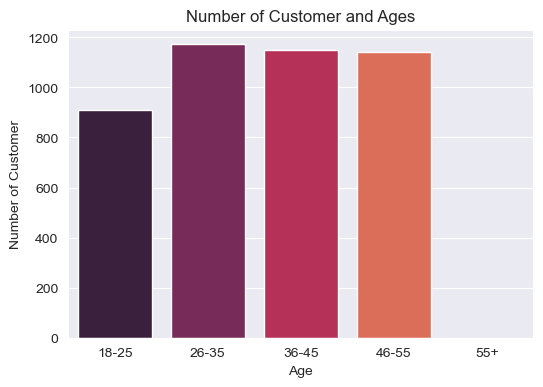

In [9]:
# Number of Customer and Ages

age18_25 = df_customer.Age[(df_customer.Age <= 25) & (df_customer.Age >= 18)]
age26_35 = df_customer.Age[(df_customer.Age <= 35) & (df_customer.Age >= 26)]
age36_45 = df_customer.Age[(df_customer.Age <= 45) & (df_customer.Age >= 36)]
age46_55 = df_customer.Age[(df_customer.Age <= 55) & (df_customer.Age >= 46)]
age55above = df_customer.Age[df_customer.Age >= 56]

x = ["18-25","26-35","36-45","46-55","55+"]
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

plt.figure(figsize=(6,4))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Number of Customer and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.show()

### Label Encoding

In [10]:
print(df_customer['Gender'].unique())
print(df_customer['Customer Segment'].unique())
print(df_customer['Income'].unique())

['male' 'female']
['Small Business' 'Corporate' 'Middle class']
['High' 'Low' 'Medium']


In [11]:
# label_encoder object knows how to understand word labels.
gender_encoder = preprocessing.LabelEncoder()
segment_encoder = preprocessing.LabelEncoder()
income_encoder =  preprocessing.LabelEncoder()
    
# Encode labels in column 
df_customer['age'] = df_customer.Age
df_customer['gender']= gender_encoder.fit_transform(df_customer['Gender'])
df_customer['customer_segment']= segment_encoder.fit_transform(df_customer['Customer Segment'])
df_customer['income_segment']= income_encoder.fit_transform(df_customer['Income'])

 
print("gender_encoder",df_customer['gender'].unique())
print("segment_encoder",df_customer['customer_segment'].unique())
print("income_encoder",df_customer['income_segment'].unique())

gender_encoder [1 0]
segment_encoder [2 0 1]
income_encoder [0 1 2]


In [12]:
df_customer.columns

Index(['CustomerID', 'Gender', 'Age', 'Income', 'Zipcode', 'Customer Segment',
       'age', 'gender', 'customer_segment', 'income_segment'],
      dtype='object')

In [13]:
df_customer.iloc[:,6:]

,age,gender,customer_segment,income_segment
0,53,1,2,0
1,22,0,2,1
2,29,0,0,0
3,29,1,1,2
4,36,1,2,1
...,...,...,...,...
4367,22,0,0,0
4368,23,1,1,0
4369,40,1,1,2
4370,37,1,1,2


## ELBOW - Kmeans - Customer Demographics

The elbow method checks the consistency of clusters. It finds the ideal number of clusters in data. Explained variance considers the percentage of variance explained and derives an ideal number of clusters. Suppose the deviation percentage explained is compared with the number of clusters. In that case, the first cluster adds a lot of information, but at some point, explained variance decreases, giving an angle on the graph. At the moment, the number of clusters is selected.

The elbow method runs k-means clustering on the dataset for a range of values for k (e.g., from 1–10), and then for each value of k, it computes an average score for all clusters.

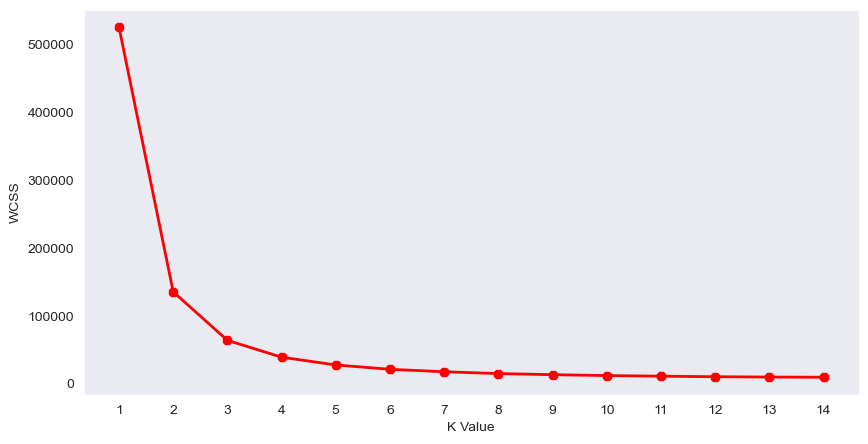

In [14]:
# Heading Required

wcss = []
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_customer.iloc[:,6:])   #<=================== Check df_customer
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,5))    
plt.grid()
plt.plot(range(1,15),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,15,1))
plt.ylabel("WCSS")
plt.show()

### Hierarchical Clustering Dendrogram

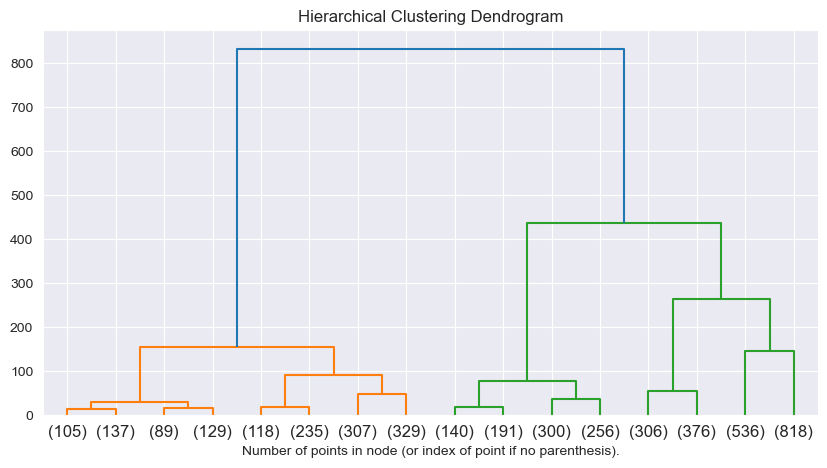

In [15]:
#function to plot dendrogram

def plot_dendrogram(model, **kwargs):
    
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_customer.iloc[:,6:])  #<==========================df_customer

plt.figure(figsize=(10,5))  
plt.title("Hierarchical Clustering Dendrogram")

# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)

plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Perform Kmeans

In [16]:
# Perfomr kmeans

km = KMeans(n_clusters=15)
clusters = km.fit_predict(df_customer.iloc[:,6:])

# saving prediction back to raw dataset
df_customer['cluster'] = clusters

df_customer.iloc[:,6:]

,age,gender,customer_segment,income_segment,cluster
0,53,1,2,0,9
1,22,0,2,1,3
2,29,0,0,0,13
3,29,1,1,2,13
4,36,1,2,1,6
...,...,...,...,...,...
4367,22,0,0,0,3
4368,23,1,1,0,5
4369,40,1,1,2,12
4370,37,1,1,2,4


In [17]:
df_customer

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment,age,gender,customer_segment,income_segment,cluster
0,13089,male,53,High,8625,Small Business,53,1,2,0,9
1,15810,female,22,Low,87797,Small Business,22,0,2,1,3
2,15556,female,29,High,29257,Corporate,29,0,0,0,13
3,13137,male,29,Medium,97818,Middle class,29,1,1,2,13
4,16241,male,36,Low,79200,Small Business,36,1,2,1,6
...,...,...,...,...,...,...,...,...,...,...,...
4367,17763,female,22,High,57980,Corporate,22,0,0,0,3
4368,16078,male,23,High,38622,Middle class,23,1,1,0,5
4369,13270,male,40,Medium,57985,Middle class,40,1,1,2,12
4370,15562,male,37,Medium,91274,Middle class,37,1,1,2,4


In [18]:
df_customer.columns

Index(['CustomerID', 'Gender', 'Age', 'Income', 'Zipcode', 'Customer Segment',
       'age', 'gender', 'customer_segment', 'income_segment', 'cluster'],
      dtype='object')

In [19]:
df_customer = df_customer[['CustomerID', 'Gender', 'Age', 'Income', 'Zipcode', 'Customer Segment', 'cluster']]

df_customer.head()

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment,cluster
0,13089,male,53,High,8625,Small Business,9
1,15810,female,22,Low,87797,Small Business,3
2,15556,female,29,High,29257,Corporate,13
3,13137,male,29,Medium,97818,Middle class,13
4,16241,male,36,Low,79200,Small Business,6


In [20]:
df_customer.cluster.unique()

array([ 9,  3, 13,  6,  7, 11,  5,  4,  1, 10,  8, 12,  0, 14,  2])

# EDA - Cluster Level

In [21]:
def plotting_percentages(df, col, target, text_size=10):
    x, y = col, target
    
    # Temporary dataframe with percentage values
    temp_df = df.groupby(x)[y].value_counts(normalize=True)
    temp_df = temp_df.mul(100).rename('percent').reset_index()

    # Sort the column values for plotting    
    order_list = list(df[col].unique())
    order_list.sort()

    # Plot the figure
    sns.set(font_scale=1.5)
    g = sns.catplot(x=x, y='percent', hue=y, kind='bar', data=temp_df, 
                    height=8, aspect=2, order=order_list, legend_out=False)
    g.ax.set_ylim(0,100)

    # Loop through each bar in the graph and add the percentage value    
    for p in g.ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt_x = p.get_x() + p.get_width() / 2  # center the text
        txt_y = p.get_height()
        g.ax.text(txt_x, txt_y, txt, ha='center', va='bottom', fontsize=text_size)
        
    # Set labels and title
    plt.title(f'{col.title()} By Percent {target.title()}', 
              fontdict={'fontsize': 30})
    plt.xlabel(f'{col.title()}', fontdict={'fontsize': 20})
    plt.ylabel(f'{target.title()} Percentage', fontdict={'fontsize': 20})
    plt.xticks(rotation=75)
    return g

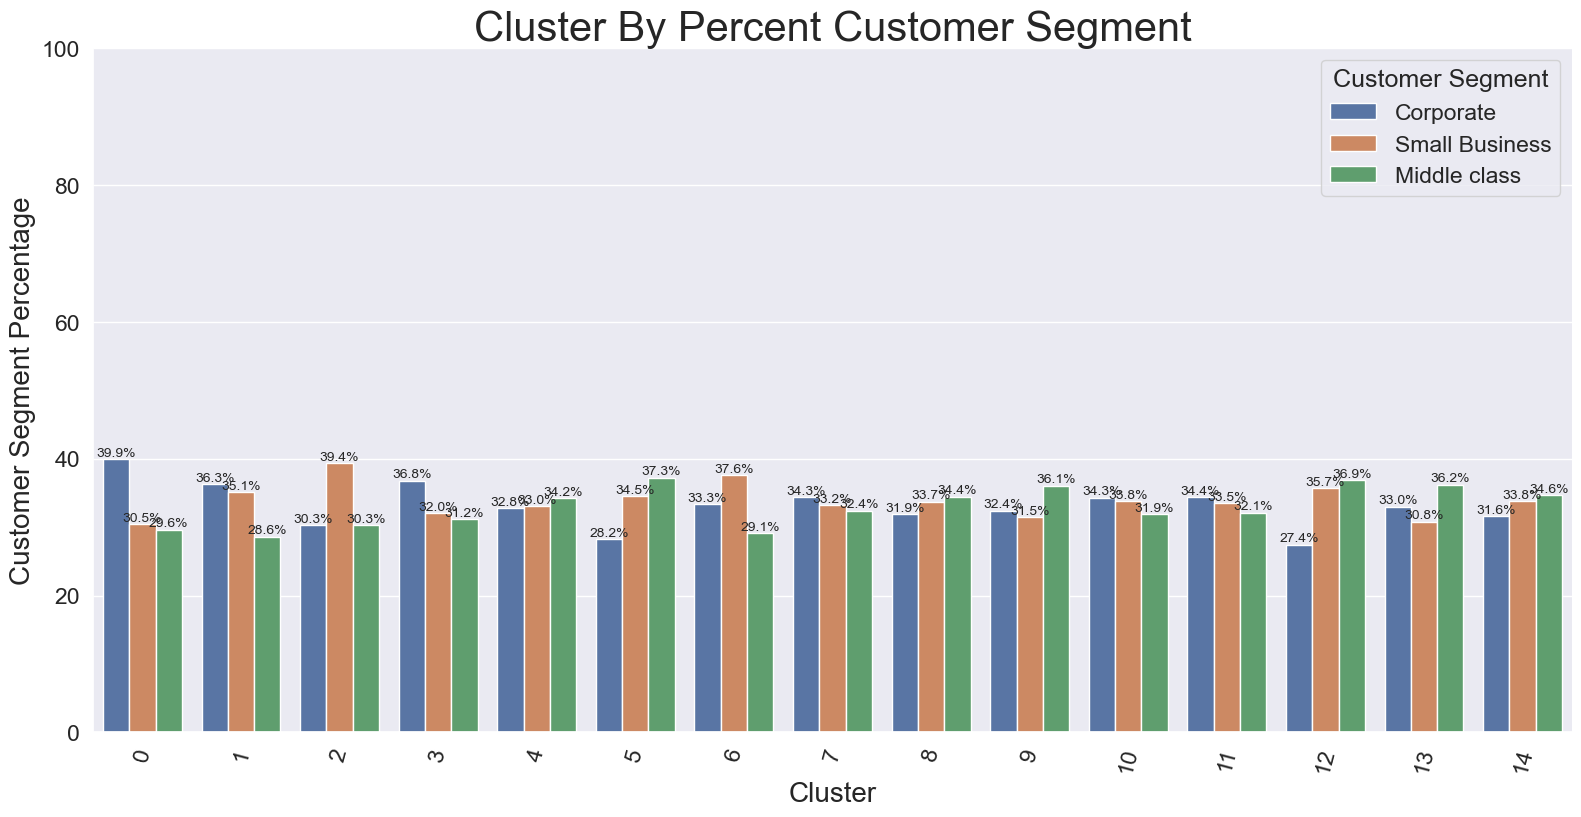

In [22]:
plotting_percentages(df_customer, 'cluster', 'Customer Segment')

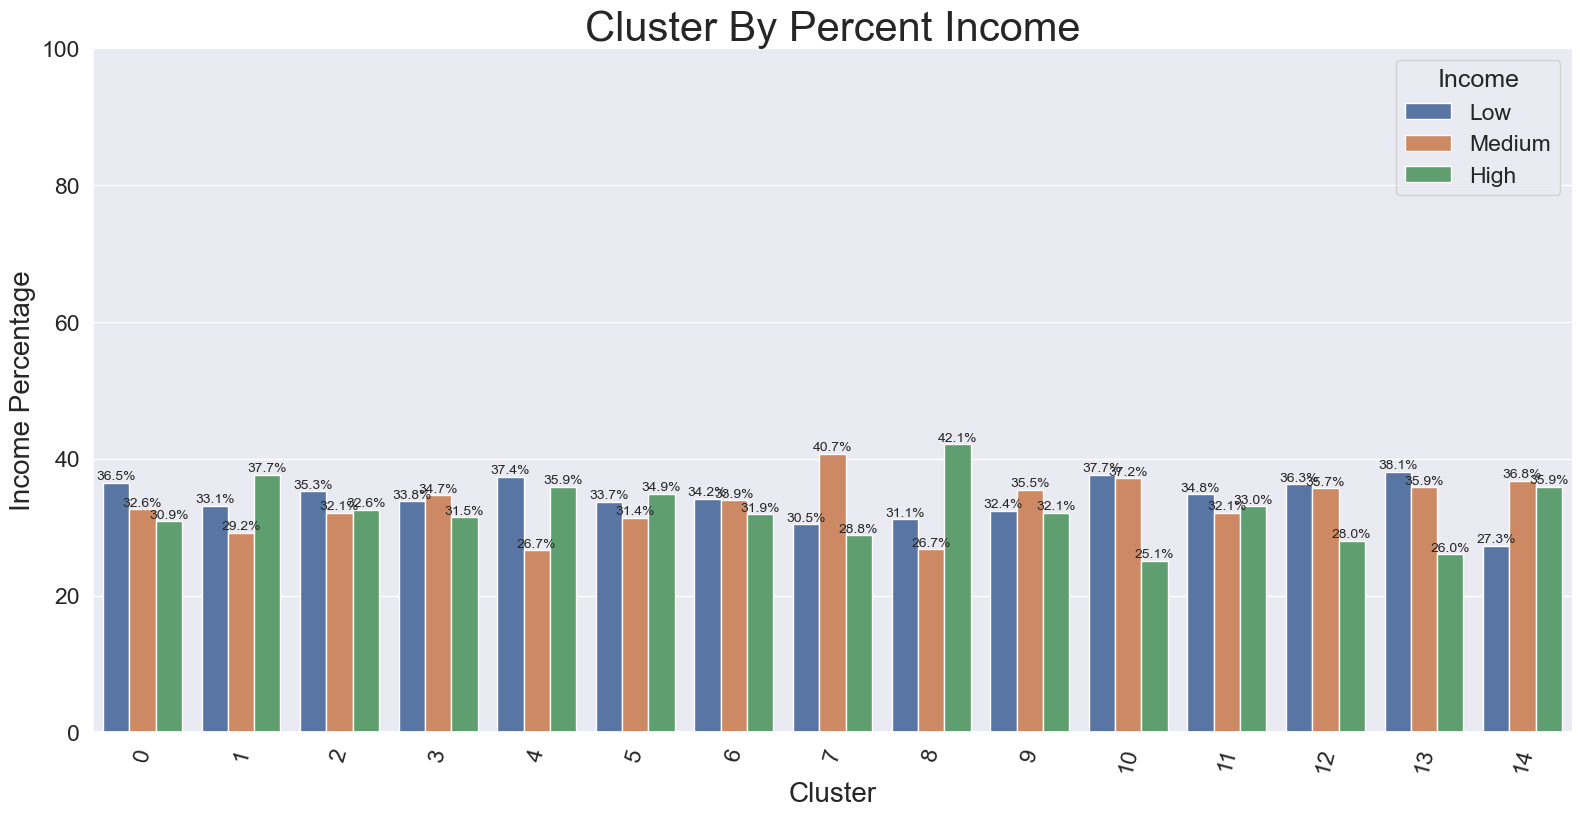

In [23]:
plotting_percentages(df_customer, 'cluster', 'Income')

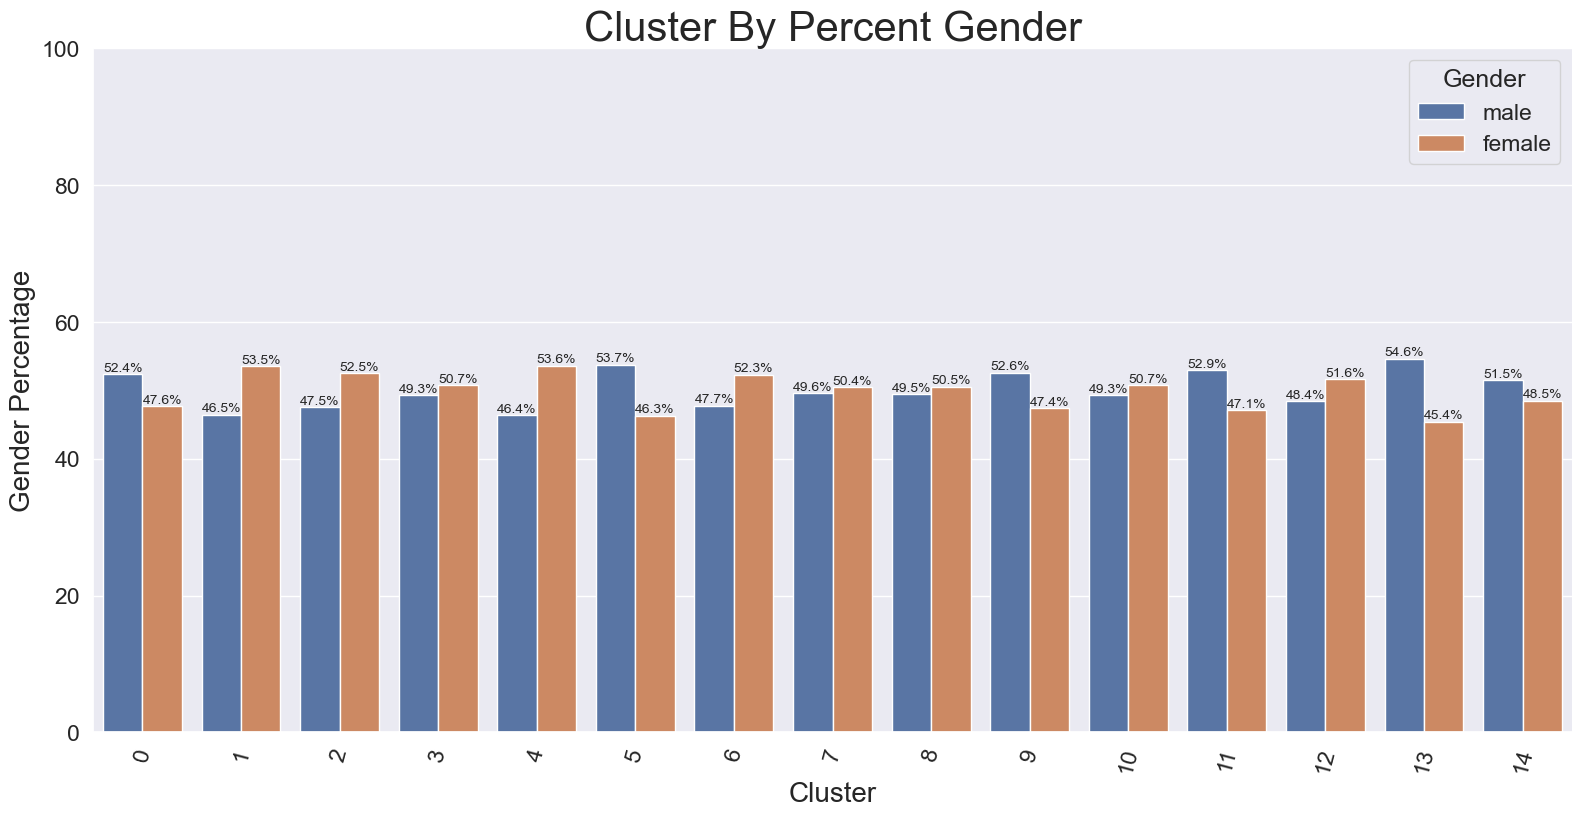

In [24]:
plotting_percentages(df_customer, 'cluster', 'Gender')

### Avg Age per Cluster

In [25]:
df_customer.head()

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment,cluster
0,13089,male,53,High,8625,Small Business,9
1,15810,female,22,Low,87797,Small Business,3
2,15556,female,29,High,29257,Corporate,13
3,13137,male,29,Medium,97818,Middle class,13
4,16241,male,36,Low,79200,Small Business,6


<Axes: xlabel='cluster'>

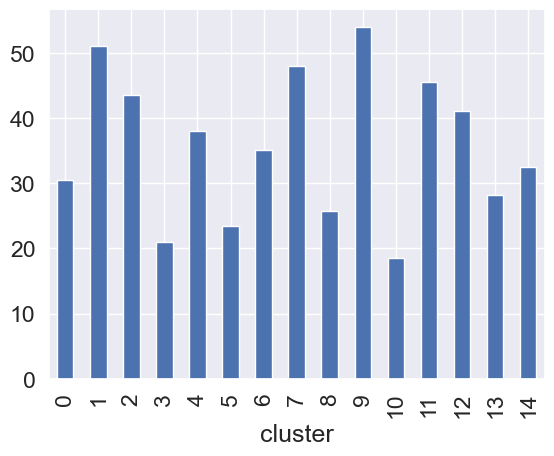

In [26]:
df_customer.groupby('cluster').Age.mean().plot(kind='bar')

In [27]:
df_order.shape

(272404, 9)

In [28]:
order_cluster_mapping = pd.merge(df_order,df_customer, on='CustomerID', how='inner')[['StockCode','CustomerID','cluster']]

order_cluster_mapping.head()

,StockCode,CustomerID,cluster
0,84029E,17850,7
1,71053,17850,7
2,21730,17850,7
3,84406B,17850,7
4,22752,17850,7


### Generate ScoreDF

In [29]:
score_df = order_cluster_mapping.groupby(['cluster','StockCode']).count().reset_index()

score_df.head()

,cluster,StockCode,CustomerID
0,0,10002,4
1,0,10080,2
2,0,10125,4
3,0,10133,4
4,0,10135,3


In [30]:
score_df = score_df.rename(columns={'CustomerID':'Score'})

score_df.head()

,cluster,StockCode,Score
0,0,10002,4
1,0,10080,2
2,0,10125,4
3,0,10133,4
4,0,10135,3


In [31]:
order_cluster_mapping.head()

,StockCode,CustomerID,cluster
0,84029E,17850,7
1,71053,17850,7
2,21730,17850,7
3,84406B,17850,7
4,22752,17850,7


### Check for a Customer

In [32]:
# CustomerID == 17850
order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['StockCode'].unique()

array(['84029E', 71053, 21730, '84406B', 22752, '85123A', '84029G', 22633,
       22632, 20679, 21068, 21871, 82483, 21071, 82486, 37370, '82494L',
       82482, '15056BL', 22803, 22411], dtype=object)

In [33]:
# CustomerID == 17850
order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['cluster'].iloc[0]

7

In [34]:
# CustomerID == 17850
order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['StockCode'].value_counts()

StockCode
84029E     17
21730      17
85123A     17
84029G     17
22633      17
22632      17
71053      17
22752      16
21071      15
82482      15
82494L     15
37370      15
21068      15
82483      15
84406B     15
82486      14
21871      14
22411      10
22803       8
20679       7
15056BL     4
Name: count, dtype: int64

In [35]:
cluster_score_df = score_df[score_df.cluster==order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['cluster'].iloc[0]]

len(cluster_score_df.StockCode.unique())

2643

In [36]:
cluster_score_df[~cluster_score_df.StockCode.isin(order_cluster_mapping[(order_cluster_mapping.CustomerID == 17850)]['StockCode'])]

,cluster,StockCode,Score
17441,7,10002,4
17442,7,10080,2
17443,7,10120,1
17444,7,10125,7
17445,7,10133,8
...,...,...,...
20079,7,90210C,1
20080,7,90210D,1
20081,7,C2,1
20082,7,M,11


### Clustering on Product Description

In [37]:
df_product.columns

Index(['StockCode', 'Product Name', 'Description', 'Category', 'Brand',
       'Unit Price'],
      dtype='object')

In [38]:
df_product.head()

,StockCode,Product Name,Description,Category,Brand,Unit Price
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,"New unique design, great gift.High quality pla...",Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,Rounded rectangular cat-eye reading glasses. T...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,Each Nintendo 2DS kit is printed with super-hi...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,The sheerest compression stocking in its class...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38
4,84836,Stupell Industries Chevron Initial Wall D cor,Features: -Made in the USA. -Sawtooth hanger o...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99


In [39]:
missing_zero_values_table(df_product)

Your selected dataframe has 6 columns and 29912 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
StockCode,0,25954,86.8,25954,86.8,object
Product Name,0,25954,86.8,25954,86.8,object
Description,0,25954,86.8,25954,86.8,object
Brand,0,1129,3.8,1129,3.8,object
Category,0,792,2.6,792,2.6,object
Unit Price,0,118,0.4,118,0.4,float64


In [40]:
df_product = df_product.dropna()

missing_zero_values_table(df_product)

Your selected dataframe has 6 columns and 3706 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [41]:
# Remove words like we'll, you'll, they'll etc.
df_product['Description'] = df_product['Description'].replace({"'ll": " "}, regex=True)

df_product['Description'] = df_product['Description'].replace({"-": " "}, regex=True)

df_product['Description'] = df_product['Description'].replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

In [42]:
# Create word vectors from combined frames
# Make sure to make necessary imports

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

#converting text to features

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_product['Description'])

# Perform Kmeans on Description

In [43]:
#clustering your products based on text

km_des = KMeans(n_clusters=15,init='k-means++')
clusters = km_des.fit_predict(X)

df_product['cluster'] = clusters

df_product.head()

,StockCode,Product Name,Description,Category,Brand,Unit Price,cluster
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,New unique design great giftHigh quality plast...,Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99,0
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,Rounded rectangular cat eye reading glasses Th...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22,1
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,Each Nintendo 2DS kit is printed with super hi...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99,11
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,The sheerest compression stocking in its class...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38,10
4,84836,Stupell Industries Chevron Initial Wall D cor,Features Made in the USA Sawtooth hanger on ...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99,12


### Calculate Cosine Score

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords

In [45]:
def cosine_similarity_T(df,query):

    vec = TfidfVectorizer(analyzer='word', stop_words=ENGLISH_STOP_WORDS)
    vec_train = vec.fit_transform(df.Description)
    vec_query = vec.transform([query])
    
    within_cosine_similarity = []

    for i in range(len(vec_train.todense())):
        within_cosine_similarity.append(cosine_similarity(vec_train[i,:].toarray(), vec_query.toarray())[0][0])


    df['Similarity'] = within_cosine_similarity
    
    return df

In [46]:
def recommend_product(customer_id):
    
    cluster_score_df = score_df[score_df.cluster==order_cluster_mapping[order_cluster_mapping.CustomerID == customer_id]['cluster'].iloc[0]]
    
    top_5_non_bought = cluster_score_df[~cluster_score_df.StockCode.isin(order_cluster_mapping[order_cluster_mapping.CustomerID == customer_id]
                                                                         ['StockCode'])].nlargest(5, 'Score')
    print('\n--- top 5 StockCode - Non bought --------\n')
    print(top_5_non_bought)

    print('\n-------Recommendations Non bought ------\n')
    print(df_product[df_product.StockCode.isin(top_5_non_bought.StockCode)]['Product Name'])
    
    
    cust_orders = df_order[df_order.CustomerID == customer_id][['CustomerID','StockCode']]
        
    top_orders = cust_orders.groupby(['StockCode']).count().reset_index()
    top_orders = top_orders.rename(columns = {'CustomerID':'Counts'})
    top_orders['CustomerID'] = customer_id
    
    top_5_bought = top_orders.nlargest(5,'Counts')
    
    
    print('\n--- top 5 StockCode - bought --------\n')
    
    print(top_5_bought)
    
    print('\n-------Stock code Product (Bought) - Description cluster Mapping------\n')
    top_clusters = df_product[df_product.StockCode.isin(top_5_bought.StockCode.tolist())][['StockCode','cluster']]
    print(top_clusters)
    
    df = df_product[df_product['cluster']==df_product[df_product.StockCode==top_clusters.StockCode.iloc[0]]['cluster'].iloc[0]]
    query = df_product[df_product.StockCode==top_clusters.StockCode.iloc[0]]['Description'].iloc[0]
    
    print("\nquery\n")
    
    print(query)
    
    recomendation = cosine_similarity_T(df,query)
    
    return recomendation.nlargest(3,'Similarity')

### Recommendations

In [47]:
#recommend_product(13137)

In [48]:
#recommend_product(15127)

In [49]:
#recommend_product(13047)